In [67]:
import matplotlib.pyplot as plt

import Framework.Confounder_Injection as CI
import Framework.Models as Models
import importlib
importlib.reload(Models)
importlib.reload(CI)
import torch
import pandas as pd
import numpy as np
import seaborn as sbs
import matplotlib.pyplot as plt
import time
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from torch import nn
from ray.tune import CLIReporter


In [68]:
params = [
    [[1, 4], [3, 6]], # real feature
    [[10, 12], [20, 22]] # confounder
]

# De-correlated confounders in target- and test-data

In [69]:
search_space = {
    "model":None,
    "device":"cuda",
    "loss_fn":nn.CrossEntropyLoss(),
    "epochs":500,
    "batch_size": tune.choice([32,64,128,256]),
    "optimizer":torch.optim.Adam,

    "alpha":tune.uniform(0,1),
    "lr": tune.loguniform(1e-5,1e-1),
    "weight_decay": tune.loguniform(1e-5,1e-1),
}
max_t = 500
samples = 100
target_domain_samples = 16

In [70]:
def plot_analysis(analysis):
    dfs = analysis.trial_dataframes
    ax = None  # This plots everything on the same plot
    for d in dfs.values():
        ax = d.mean_accuracy.plot(ax=ax, legend=False)

# BrNet

In [71]:
c = CI.confounder()
model = Models.Br_Net()
search_space["model"] = model
c.generate_data(mode="br_net", samples=512, overlap=0, target_domain_samples=target_domain_samples, target_domain_confounding=1, train_confounding=1, test_confounding=[1], de_correlate_confounder_target=True, de_correlate_confounder_test=True, params=params)

reporter = CLIReporter(max_progress_rows=1, max_report_frequency=120)
analysis = tune.run(c.train_tune,num_samples=samples, progress_reporter=reporter, config=search_space, scheduler=ASHAScheduler(metric="mean_accuracy", mode="max", max_t=max_t))

2022-07-13 18:43:55,296	INFO registry.py:91 -- Detected unknown callable for trainable. Converting to class.
2022-07-13 18:43:58,051	WARNING worker.py:1404 -- Warning: The actor ImplicitFunc is very large (16 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


== Status ==
Current time: 2022-07-13 18:44:00 (running for 00:00:05.29)
Memory usage on this node: 17.5/30.5 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 256.000: None | Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/9.88 GiB heap, 0.0/4.94 GiB objects
Result logdir: /home/raffi/ray_results/train_tune_2022-07-13_18-43-55
Number of trials: 17/100 (16 PENDING, 1 RUNNING)
+------------------------+----------+----------------------+-----------+-------------+----------------+
| Trial name             | status   | loc                  |     alpha |          lr |   weight_decay |
|------------------------+----------+----------------------+-----------+-------------+----------------|
| train_tune_fc21f_00000 | RUNNING  | 10.188.40.131:498349 | 0.333873  | 0.050127    |      0.0409224 |
| train_tune_fc21f_00001 | PENDING  |                      | 0.0971708 | 0.000641899 |      0.0012546 |
+--------------------

2022-07-13 18:52:42,976	INFO tune.py:747 -- Total run time: 527.68 seconds (527.27 seconds for the tuning loop).


Result for train_tune_fc21f_00080:
  date: 2022-07-13_18-52-42
  done: true
  experiment_id: 1b952c3b6706490db55cfdeb8f1d5f36
  hostname: fedora
  iterations_since_restore: 500
  mean_accuracy: 0.5
  node_ip: 10.188.40.131
  pid: 498420
  time_since_restore: 233.9853162765503
  time_this_iter_s: 0.16619324684143066
  time_total_s: 233.9853162765503
  timestamp: 1657731162
  timesteps_since_restore: 0
  training_iteration: 500
  trial_id: fc21f_00080
  warmup_time: 0.019198179244995117
  
== Status ==
Current time: 2022-07-13 18:52:42 (running for 00:08:47.32)
Memory usage on this node: 16.5/30.5 GiB
Using AsyncHyperBand: num_stopped=100
Bracket: Iter 256.000: 0.5 | Iter 64.000: 0.5 | Iter 16.000: 0.5 | Iter 4.000: 0.5 | Iter 1.000: 0.5
Resources requested: 0/16 CPUs, 0/0 GPUs, 0.0/9.88 GiB heap, 0.0/4.94 GiB objects
Result logdir: /home/raffi/ray_results/train_tune_2022-07-13_18-43-55
Number of trials: 100/100 (100 TERMINATED)
+------------------------+------------+--------------------

{'model': Br_Net(
   (linear_relu_stack): Sequential(
     (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
     (1): Tanh()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1))
     (4): Tanh()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
     (7): Tanh()
     (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (9): Flatten(start_dim=1, end_dim=-1)
     (10): Linear(in_features=32, out_features=2, bias=True)
   )
 ),
 'device': 'cuda',
 'loss_fn': CrossEntropyLoss(),
 'epochs': 500,
 'batch_size': 128,
 'optimizer': torch.optim.adam.Adam,
 'alpha': 0.09717083420007377,
 'lr': 0.0006418994120746483,
 'weight_decay': 0.001254597736546585}

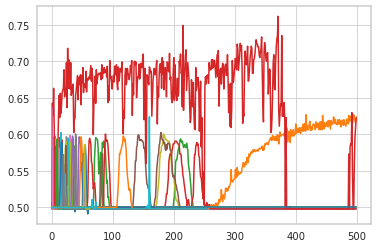

In [72]:
plot_analysis(analysis)
analysis.get_best_config(metric="mean_accuracy", mode="max", scope="last-10-avg")

# BrNet_CF_free

In [73]:
c = CI.confounder()
model = Models.Br_Net_CF_free(alpha=None)
search_space["model"] = model
c.generate_data(mode="br_net", samples=512, overlap=0, target_domain_samples=target_domain_samples, target_domain_confounding=1, train_confounding=1, test_confounding=[1], de_correlate_confounder_target=True, de_correlate_confounder_test=True, params=params)

reporter = CLIReporter(max_progress_rows=1, max_report_frequency=120)
analysis = tune.run(c.train_tune,num_samples=samples, progress_reporter=reporter, config=search_space, scheduler=ASHAScheduler(metric="mean_accuracy", mode="max", max_t=max_t))

2022-07-13 18:52:45,324	INFO registry.py:91 -- Detected unknown callable for trainable. Converting to class.
2022-07-13 18:52:48,482	WARNING worker.py:1404 -- Warning: The actor ImplicitFunc is very large (16 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


== Status ==
Current time: 2022-07-13 18:52:51 (running for 00:00:06.01)
Memory usage on this node: 17.6/30.5 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 256.000: None | Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/9.88 GiB heap, 0.0/4.94 GiB objects
Result logdir: /home/raffi/ray_results/train_tune_2022-07-13_18-52-45
Number of trials: 17/100 (16 PENDING, 1 RUNNING)
+------------------------+----------+----------------------+-----------+-------------+----------------+
| Trial name             | status   | loc                  |     alpha |          lr |   weight_decay |
|------------------------+----------+----------------------+-----------+-------------+----------------|
| train_tune_381cc_00000 | RUNNING  | 10.188.40.131:501438 | 0.333873  | 0.050127    |      0.0409224 |
| train_tune_381cc_00001 | PENDING  |                      | 0.0971708 | 0.000641899 |      0.0012546 |
+--------------------

2022-07-13 18:54:12,170	WARNING util.py:214 -- The `callbacks.on_trial_result` operation took 0.519 s, which may be a performance bottleneck.
2022-07-13 18:54:12,173	WARNING util.py:214 -- The `process_trial_result` operation took 0.521 s, which may be a performance bottleneck.
2022-07-13 18:54:12,173	WARNING util.py:214 -- Processing trial results took 0.522 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-07-13 18:54:12,174	WARNING util.py:214 -- The `process_trial_result` operation took 0.523 s, which may be a performance bottleneck.


Result for train_tune_381cc_00049:
  date: 2022-07-13_18-54-11
  done: false
  experiment_id: 793b2d9688db489e9445e696d5475cf0
  hostname: fedora
  iterations_since_restore: 9
  mean_accuracy: 0.5
  node_ip: 10.188.40.131
  pid: 501527
  time_since_restore: 6.157609224319458
  time_this_iter_s: 0.9010882377624512
  time_total_s: 6.157609224319458
  timestamp: 1657731251
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 381cc_00049
  warmup_time: 0.018190622329711914
  
Result for train_tune_381cc_00052:
  date: 2022-07-13_18-54-11
  done: false
  experiment_id: dc1fef0219524748af2c1db0de89d8f1
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.5
  node_ip: 10.188.40.131
  pid: 501696
  time_since_restore: 0.5372922420501709
  time_this_iter_s: 0.5372922420501709
  time_total_s: 0.5372922420501709
  timestamp: 1657731251
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 381cc_00052
  warmup_time: 0.02293086051940918
  
Result for train_tune

2022-07-13 18:55:22,964	WARNING tune.py:682 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 


== Status ==
Current time: 2022-07-13 18:55:23 (running for 00:02:38.03)
Memory usage on this node: 21.0/30.5 GiB
Using AsyncHyperBand: num_stopped=50
Bracket: Iter 256.000: None | Iter 64.000: 0.5 | Iter 16.000: 0.5 | Iter 4.000: 0.5 | Iter 1.000: 0.5
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/9.88 GiB heap, 0.0/4.94 GiB objects
Result logdir: /home/raffi/ray_results/train_tune_2022-07-13_18-52-45
Number of trials: 83/100 (17 PENDING, 16 RUNNING, 50 TERMINATED)
+------------------------+------------+----------------------+------------+-------------+----------------+----------+--------+------------------+
| Trial name             | status     | loc                  |      alpha |          lr |   weight_decay |      acc |   iter |   total time (s) |
|------------------------+------------+----------------------+------------+-------------+----------------+----------+--------+------------------|
| train_tune_381cc_00000 | RUNNING    | 10.188.40.131:501438 | 0.333873   | 0.050127    |

2022-07-13 18:55:24,016	ERROR tune.py:743 -- Trials did not complete: [train_tune_381cc_00000, train_tune_381cc_00019, train_tune_381cc_00023, train_tune_381cc_00027, train_tune_381cc_00028, train_tune_381cc_00032, train_tune_381cc_00035, train_tune_381cc_00038, train_tune_381cc_00041, train_tune_381cc_00045, train_tune_381cc_00049, train_tune_381cc_00053, train_tune_381cc_00055, train_tune_381cc_00060, train_tune_381cc_00063, train_tune_381cc_00065, train_tune_381cc_00066, train_tune_381cc_00067, train_tune_381cc_00068, train_tune_381cc_00069, train_tune_381cc_00070, train_tune_381cc_00071, train_tune_381cc_00072, train_tune_381cc_00073, train_tune_381cc_00074, train_tune_381cc_00075, train_tune_381cc_00076, train_tune_381cc_00077, train_tune_381cc_00078, train_tune_381cc_00079, train_tune_381cc_00080, train_tune_381cc_00081, train_tune_381cc_00082]
2022-07-13 18:55:24,017	INFO tune.py:747 -- Total run time: 158.70 seconds (157.34 seconds for the tuning loop).
2022-07-13 18:55:24,019	

{'model': Br_Net_CF_free(
   (linear_relu_stack): Sequential(
     (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
     (1): Tanh()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1))
     (4): Tanh()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
     (7): Tanh()
     (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (9): Flatten(start_dim=1, end_dim=-1)
   )
   (class_predictor): Sequential(
     (0): Linear(in_features=32, out_features=2, bias=True)
   )
   (domain_predictor): Sequential(
     (0): Linear(in_features=32, out_features=2, bias=True)
   )
 ),
 'device': 'cuda',
 'loss_fn': CrossEntropyLoss(),
 'epochs': 500,
 'batch_size': 128,
 'optimizer': torch.optim.adam.Adam,
 'alpha': 0.2697252786020793,
 'lr': 0.0810751538281217,
 'weight_decay': 0.0003222

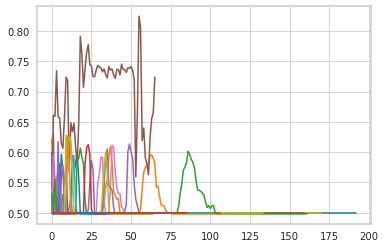

In [74]:
plot_analysis(analysis)
analysis.get_best_config(metric="mean_accuracy", mode="max", scope="last-10-avg")

# BrNet_CF_free_conditioned

In [75]:
c = CI.confounder()
model = Models.Br_Net_CF_free(alpha=None)
search_space["model"] = model
c.generate_data(mode="br_net", samples=512, overlap=0, target_domain_samples=target_domain_samples, target_domain_confounding=1, train_confounding=1, test_confounding=[1], de_correlate_confounder_target=True, de_correlate_confounder_test=True, params=params, conditioning=0)

reporter = CLIReporter(max_progress_rows=1, max_report_frequency=120)
analysis = tune.run(c.train_tune,num_samples=samples, progress_reporter=reporter, config=search_space, scheduler=ASHAScheduler(metric="mean_accuracy", mode="max", max_t=max_t))

2022-07-13 18:55:26,512	INFO registry.py:91 -- Detected unknown callable for trainable. Converting to class.
2022-07-13 18:55:29,969	WARNING worker.py:1404 -- Warning: The actor ImplicitFunc is very large (16 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


== Status ==
Current time: 2022-07-13 18:55:33 (running for 00:00:06.41)
Memory usage on this node: 17.6/30.5 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 256.000: None | Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/9.88 GiB heap, 0.0/4.94 GiB objects
Result logdir: /home/raffi/ray_results/train_tune_2022-07-13_18-55-26
Number of trials: 17/100 (16 PENDING, 1 RUNNING)
+------------------------+----------+----------------------+-----------+-------------+----------------+
| Trial name             | status   | loc                  |     alpha |          lr |   weight_decay |
|------------------------+----------+----------------------+-----------+-------------+----------------|
| train_tune_98305_00000 | RUNNING  | 10.188.40.131:503103 | 0.333873  | 0.050127    |      0.0409224 |
| train_tune_98305_00001 | PENDING  |                      | 0.0971708 | 0.000641899 |      0.0012546 |
+--------------------

2022-07-13 18:56:56,711	WARNING tune.py:682 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 


Result for train_tune_98305_00035:
  date: 2022-07-13_18-56-56
  done: false
  experiment_id: 929683ddd7824196a83e53d5b807ea0a
  hostname: fedora
  iterations_since_restore: 39
  mean_accuracy: 0.5
  node_ip: 10.188.40.131
  pid: 503169
  time_since_restore: 39.27601766586304
  time_this_iter_s: 1.0944702625274658
  time_total_s: 39.27601766586304
  timestamp: 1657731416
  timesteps_since_restore: 0
  training_iteration: 39
  trial_id: '98305_00035'
  warmup_time: 0.028549909591674805
  
== Status ==
Current time: 2022-07-13 18:56:57 (running for 00:01:30.82)
Memory usage on this node: 21.0/30.5 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 256.000: None | Iter 64.000: 0.5 | Iter 16.000: 0.5 | Iter 4.000: 0.5 | Iter 1.000: 0.5
Resources requested: 16.0/16 CPUs, 0/0 GPUs, 0.0/9.88 GiB heap, 0.0/4.94 GiB objects
Result logdir: /home/raffi/ray_results/train_tune_2022-07-13_18-55-26
Number of trials: 55/100 (17 PENDING, 16 RUNNING, 22 TERMINATED)
+------------------------+--------

2022-07-13 18:56:57,954	ERROR tune.py:743 -- Trials did not complete: [train_tune_98305_00000, train_tune_98305_00002, train_tune_98305_00012, train_tune_98305_00015, train_tune_98305_00019, train_tune_98305_00023, train_tune_98305_00024, train_tune_98305_00027, train_tune_98305_00028, train_tune_98305_00029, train_tune_98305_00032, train_tune_98305_00033, train_tune_98305_00034, train_tune_98305_00035, train_tune_98305_00036, train_tune_98305_00037, train_tune_98305_00038, train_tune_98305_00039, train_tune_98305_00040, train_tune_98305_00041, train_tune_98305_00042, train_tune_98305_00043, train_tune_98305_00044, train_tune_98305_00045, train_tune_98305_00046, train_tune_98305_00047, train_tune_98305_00048, train_tune_98305_00049, train_tune_98305_00050, train_tune_98305_00051, train_tune_98305_00052, train_tune_98305_00053, train_tune_98305_00054]
2022-07-13 18:56:57,955	INFO tune.py:747 -- Total run time: 91.44 seconds (89.90 seconds for the tuning loop).
2022-07-13 18:56:57,955	WA

{'model': Br_Net_CF_free(
   (linear_relu_stack): Sequential(
     (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
     (1): Tanh()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1))
     (4): Tanh()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
     (7): Tanh()
     (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (9): Flatten(start_dim=1, end_dim=-1)
   )
   (class_predictor): Sequential(
     (0): Linear(in_features=32, out_features=2, bias=True)
   )
   (domain_predictor): Sequential(
     (0): Linear(in_features=32, out_features=2, bias=True)
   )
 ),
 'device': 'cuda',
 'loss_fn': CrossEntropyLoss(),
 'epochs': 500,
 'batch_size': 128,
 'optimizer': torch.optim.adam.Adam,
 'alpha': 0.26331465841529544,
 'lr': 0.04157992369405147,
 'weight_decay': 0.01580

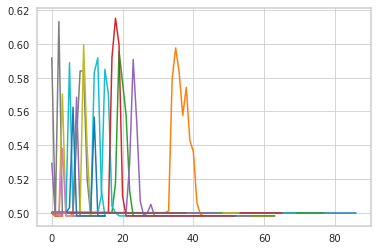

In [76]:
plot_analysis(analysis)
analysis.get_best_config(metric="mean_accuracy", mode="max", scope="last-10-avg")
#analysis.best_dataframe(metric="mean_accuracy", mode="max", scope="last-10-avg").plot()

# BrNet_DANN

In [ ]:
c = CI.confounder()
model = Models.Br_Net_DANN(alpha=None)
search_space["model"] = model
c.generate_data(mode="br_net", samples=512, overlap=0, target_domain_samples=target_domain_samples, target_domain_confounding=1, train_confounding=1, test_confounding=[1], de_correlate_confounder_target=True, de_correlate_confounder_test=True, params=params)

reporter = CLIReporter(max_progress_rows=1, max_report_frequency=120)
analysis = tune.run(c.train_tune,num_samples=samples, progress_reporter=reporter, config=search_space, scheduler=ASHAScheduler(metric="mean_accuracy", mode="max", max_t=max_t))

2022-07-13 18:57:00,204	INFO registry.py:91 -- Detected unknown callable for trainable. Converting to class.


In [ ]:
plot_analysis(analysis)
analysis.get_best_config(metric="mean_accuracy", mode="max", scope="last-10-avg")